In [30]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, r2_score

market_data = yf.download('SPY', start='2017-01-01', end='2021-10-21')

[*********************100%***********************]  1 of 1 completed


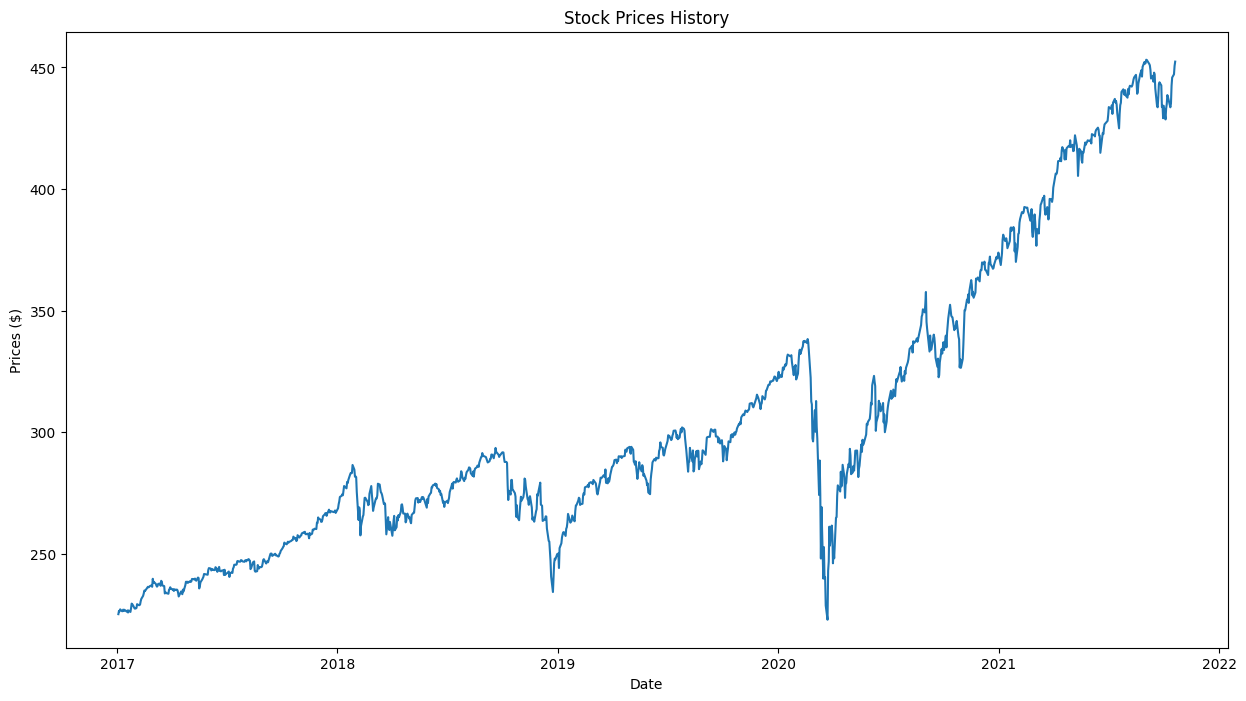

In [31]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(market_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')
plt.savefig("spy_close_prices.png")

In [32]:
close_prices = market_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.75)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [33]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [34]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dense_4 (Dense)             (None, 25)                2525      
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
847/847 [==============================] - 16s 15ms/step - loss: 0.0014
Epoch 2/3
847/847 [==============================] - 14s 16ms/step - loss: 6.9168e-04
Epoch 3/3
847/847 [==============================] - 13s 15ms/step - loss: 4.5913e-04


In [36]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


10/10 [==============================] - 1s 15ms/step


In [ ]:
data = market_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.savefig("spy_predictions.png")
plt.show()

In [ ]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(market_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [ ]:
# Compute the metrics for the linear regression model
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print(f"The root mean squared error is {rmse}.")